In [57]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from tqdm import tqdm
import os
import torch
from torch_geometric.data import Data
from torch_geometric.utils import degree as deg


def path_link(path:str):
    sys.path.append(path)

path_link('/master/code/lib')

import simulation_v2 as sim
import features as ft
import utils.loading as load
import utils.testing_gen as gen
from utils.tools import array2List, makedirs, writeJson
import utils.nn_gen as nn_gen

import pandas as pd



DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')


#PATH = 'master/code/runs1'
#PATH = 'master/code/runs2'
#PATH = ['/master/code/analyze_models/exps/test_new_activation_0']
PATH = ['/master/code/results/models']

#DISPLAY_PATH = 'master/code/display_l1'
#DISPLAY_PATH = '/master/code/display_l1_2'
#DISPLAY_PATH = ['/master/code/analyze_models/display/test_new_activation_0']
DISPLAY_PATH = ['/master/code/results/figures']

MODEL_PATH = '/master/code/models'

NB_SIM = 1



class ID():
    def __init__(self):
        self.features_x = None
        self.features_edge = None
        self.MLP_hidden = None
        self.l1 = None
        self.dropout = None
        self.layer_norm = None
        self.nb_layer = None
        self.model = None
        self.dt = None

        self.data_type = None


    def get_name(self):
        name = f'{self.model}_'

        if self.data_type:
            name += f'dType-{self.data_type}_'

        if self.features_x:
            name += f'featX-{self.features_x}_'

        if self.features_edge:
            name += f'featE-{self.features_edge}_'

        if self.MLP_hidden:
            name += f'nbHiddenMLP-{self.MLP_hidden}_'

        if self.l1:
            name += f'l1-{self.l1}_'

        if self.dropout:
            name += f'dropout-{self.dropout}_'

        if self.layer_norm:
            name += f'layerNorm-{self.layer_norm}_'

        if self.nb_layer:
            name += f'nbLayer-{self.nb_layer}_'

        if self.dt:
            name += f'dt-{self.dt}_'


        if name.endswith('_'):
            name = name[:-1]

        return name
    

    def load_from_wb(self, name):

        splits = name.split('_')

        self.model = 'simplest'

        if 'baseline' in name:
            self.model = 'baseline'

        if 'complex' in name:
            print(name)
            self.model = 'gnn' 

        if 'gat' in name:
            self.model = 'gat'


        #########

        if 'noisy' in name:
            self.data_type = 'noisy'

        elif 'normal' in name:
            self.data_type = 'normal'

        for s in splits:
            if 'featX' in s:
                self.features_x =s.split('-')[-1]
            if 'featE' in s:
                self.features_edge = s.split('-')[-1]
            if 'nbHiddenMLP' in s:
                self.MLP_hidden = int(s.split('-')[-1])
            if 'l1' in s:
                self.l1 = float(s.split('-')[-1])
            if 'dropout' in s:
                self.dropout = s.split('-')[0]
            if 'layerNorm' in s:
                self.layer_norm = s.split('-')[-1]
            if 'nbLayer' in s:
                self.nb_layer = int(s.split('-')[-1])
            if 'dt' in s:
                self.dt = float(s.split('-')[-1])


            if 'dType' in s:
                self.features_x =s.split('-')[-1]



        



def getParams():
    params = gen.Parameters_Simulation()  

    {'dt': 0.001, 'v0': 60, 'k': 70, 'epsilon': 0.5, 'tau': 3.5, 'R': 1, 'N': 200, 'boundary': 100, 'nbStep': 150}

    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 0
    params.N = 200
    params.boundary = 100
    params.nbStep = 300


    params.noisy = 1        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params



def find_models_and_paths(model_path:str, display_path:str)->tuple:
    model_list = []
    out_list = []
    
    nb = 0

    for root, dirs, files in os.walk(model_path):
        for file in files:
            if file.endswith('.pt'):
                f = os.path.join(root, file)
                model_list.append(f)

                # add ID detection here

                id = ID()

                id.load_from_wb(f.split('/')[-3])

                path_d = id.get_name()
                

                #f_display = makedirs(display_path)

                out_list.append(path_d)
                nb += 1


    return model_list, out_list



def get_gt_preds(model, graphs, device = DEVICE):

    list_gt = []
    list_preds = []

    with torch.no_grad():
    
        for graph in graphs:

            graph = graph.to(device)
            list_gt.append(graph.y[:, 0, :].cpu().detach().numpy())

            list_preds.append(model(graph).cpu().detach().numpy())

    return list_gt, list_preds



def plotBoxPlot(diff, vals, bins, xlabel = 'X values', ylabel = 'y values', showfliers = False):
    

    groups = np.digitize(diff, bins)
    grouped_errors = {i: [] for i in range(len(bins)+1)}

    for idx, group in enumerate(groups):
        grouped_errors[group].append(vals[idx])

    print(len(list(grouped_errors.keys())))

    centers = [bins[0]-1] + [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)] + [bins[-1] + 1]
    print(len(centers))
    data_to_plot = [grouped_errors[k] for k in sorted(grouped_errors.keys())]
    medians = [np.median(g) if g else np.nan for g in data_to_plot]

    boxprops = dict(linestyle='-', linewidth=2, color='black')  # Custom box properties
    medianprops = dict(linestyle='-', linewidth=0, color='orange')  # Invisible median line
    boxplot_elements = plt.boxplot(data_to_plot, positions=centers, boxprops=boxprops, medianprops=medianprops, showfliers=showfliers, widths = 0.2)

    plt.plot(centers, medians, 'o-', color='orange', label='Medians')


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return medians


########################################


def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm




########################################


def getStdMessage(model, attr):
    model.eval()
    with torch.no_grad():
        v = model.GNN.message(None, None, attr).cpu().detach().numpy()
    return v



def plotStdMessage(messages):

    std = np.std(messages, axis = 0)

    plt.plot(std)
    plt.xlabel('Features')
    plt.ylabel('Standard Deviation')

    return std


########################################



def plotDegreeLoss(degreeList, errorList):
    maxBin = min(np.max(degreeList), 8)
    bins = np.arange(maxBin+2) - 0.5

    plotBoxPlot(degreeList, errorList, bins, xlabel = 'Degree', ylabel = 'L1 Error')

    return None


def get_degree_list(grpahs):

    deg_list = []

    for graph in grpahs:
        degs = deg(graph.edge_index[0, :], num_nodes=graph.x.size(0))
        deg_list.append(degs)

    return deg_list



################################################


def plotDistLoss(distList, errorList):
    bins = np.linspace(0, 6, 20)

    plotBoxPlot(distList, errorList, bins, xlabel = 'Distance', ylabel = 'L1 Error')

    return None


###############################################

def get_se(gts, preds):

    vals = (gts - preds) ** 2

    return vals

def get_ma(gts, preds):

    vals = np.abs(gts - preds)

    return vals


def get_mae(gts, preds):

    vals = np.abs(gts - preds)

    return np.mean(vals), np.std(vals)


###############################################


def error_speed(model, graphs):

    speed_norm = []
    errors = []

    for graph in graphs:
        speeds = graph.x[:, 2:4]
        norm = np.linalg.norm(speeds.cpu().detach().numpy(), axis= -1).reshape(-1)
        speed_norm.extend(norm.tolist())

        preds = model(graph).cpu().detach().numpy()
        y = graph.y.cpu().detach().numpy()[:, 0, :]

        ers = np.mean((np.abs(preds - y)), axis = -1)      ## MAE here



        errors.extend(ers.tolist())

    speed_norm = np.array(speed_norm)
    errors = np.array(errors)

    print(errors.shape)
    print(speed_norm.shape)

    plt.scatter(speed_norm, errors)
    plt.grid()
    plt.xlabel('Speed norm')
    plt.ylabel('L1 Error')


    return speed_norm, errors




############################################################

def get_pd_dict(d: dict) -> pd.DataFrame:
    df = pd.DataFrame.from_dict(d)
    # keys are columns by default (^^)

    return df


In [32]:
list_exp = PATH
list_disp = DISPLAY_PATH

params = getParams()                # adapt ...
data_gt = gen.get_mult_data(params, NB_SIM)
graphs_gt = gen.sims2Graphs(data_gt)

i = 0

models_dir = list_exp[i]
path_dis = list_disp[i]

models, paths = find_models_and_paths(models_dir, path_dis)

v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 299/299 [00:03<00:00, 98.91it/s] 


In [33]:
print(params.__dict__)

{'dt': 0.001, 'v0': 60, 'k': 70, 'epsilon': 0.5, 'tau': 3.5, 'R': 0, 'N': 200, 'boundary': 100, 'nbStep': 300, 'noisy': 1, 'features_x': 'delta', 'features_edge': 'first'}


In [34]:
i = 0

models_dir = list_exp[i]
path_dis = list_disp[i]

j = 0
model_p = models[j]
path = paths[j]

#model = load.loadModel(load.getModelName(model_p), path=MODEL_PATH)
#std_dict = torch.load(model_p)
#model.load_state_dict(std_dict)
#model.eval()
#model = model.to(DEVICE)

In [35]:
print(path)

simplest_dType-noisy_featX-delta_l1-0.0001_dt-0.001


In [36]:
print(list_disp)

['/master/code/results/figures']


In [37]:
path_display_exp = makedirs(os.path.join(path_dis, path))

In [38]:

model = load.loadModel(load.getModelName(model_p), path=MODEL_PATH)
std_dict = torch.load(model_p, map_location='cpu')
model.load_state_dict(std_dict)
model.eval()
model = model.to(DEVICE)

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout


In [39]:
gt, preds = get_gt_preds(model, graphs_gt)

In [42]:
print(preds[0].shape)

(200, 2)


In [10]:
error_norm = []
error_angle = []
for i in range(len(preds)):
    e_norm, e_angle = errorsDiv(preds[i], gt[i])

    error_norm.append(e_norm)
    error_angle.append(e_angle)

error_angle = np.stack(error_angle).reshape(-1)
error_norm = np.stack(error_norm).reshape(-1)


In [45]:
errors_MAE = []

for i in range(len(preds)):
    e = get_ma(preds[i], gt[i])
    errors_MAE.append(e)

errors_MAE = np.stack(errors_MAE).reshape(-1)


In [12]:
d = {}

d['MAE'] = float(np.mean(errors_MAE))
d['MAE-std'] = float(np.std(errors_MAE))

d['angle-error'] =float(np.mean(error_angle))
d['angle-std'] = float(np.std(error_angle))

d['norm-error'] = float(np.mean(error_norm))
d['norm-std'] = float(np.std(error_norm))

In [13]:
print(d)

{'MAE': 0.0010103468084707856, 'MAE-std': 0.0017786800162866712, 'angle-error': 0.0006310850731097162, 'angle-std': 0.0009691559243947268, 'norm-error': 0.034862447530031204, 'norm-std': 0.13877320289611816}


In [14]:
writeJson(d, os.path.join(path_display_exp, 'data.json'))

In [15]:
messages = getStdMessage(model, graphs_gt[0].edge_attr.to(DEVICE))
_ =  plotStdMessage(messages)
plt.savefig(os.path.join(path_display_exp, 'messages.png'))
plt.close()

In [49]:
deg_list = get_degree_list(graphs_gt)

In [50]:
print(deg_list[0].shape)

torch.Size([200])


In [17]:
print(errors_MAE)

[1.8556304e-03 5.3842366e-04 1.4140252e-03 ... 5.2884221e-05 1.3627053e-03
 1.2725592e-04]


In [55]:
def plotDegreeLoss(degreeList, model, graphs, device = DEVICE):

    list_gt, list_preds = get_gt_preds(model, graphs, device = device)


    errors_MSE = []

    for i in range(len(list_gt)):
        e = np.mean(get_ma(list_preds[i], list_gt[i]), axis = -1)
        
        errors_MSE.append(e)

    errors_MSE = np.stack(errors_MSE).reshape(-1)


    degList = [degreeList[i].cpu().detach().numpy() for i in range(len(degreeList))]
    degList = np.stack(degList).reshape(-1)

    maxBin = min(np.max(degList), 8)
    bins = np.arange(maxBin+2) - 0.5

    plotBoxPlot(degList, errors_MSE, bins, xlabel = 'Degree', ylabel = 'L1 Error')

    return None

6
6


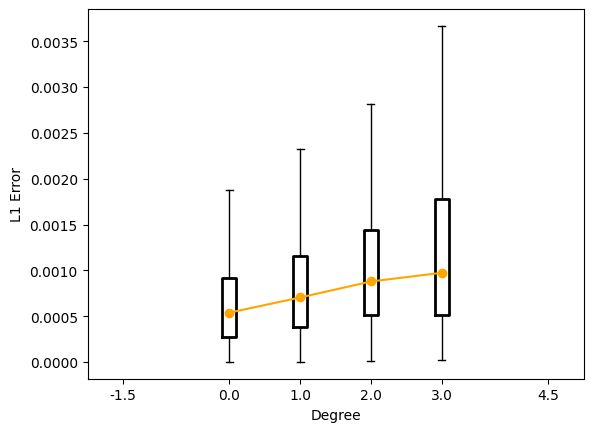

In [56]:
plotDegreeLoss(deg_list, model, graphs_gt)

In [20]:
plt.savefig(os.path.join(path_display_exp, 'errors-degs.png'))
plt.close()

(57800,)
(57800,)


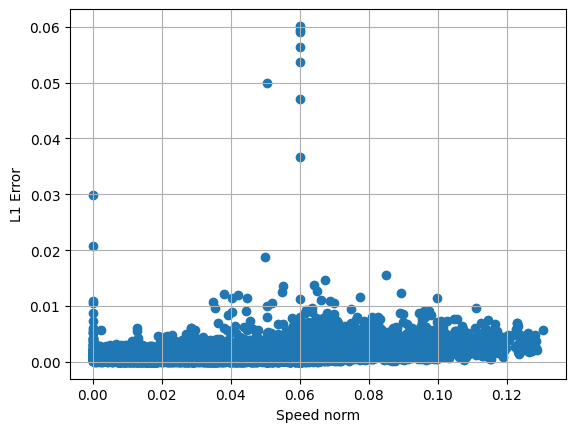

In [58]:
speed_norm, errors = error_speed(model, graphs_gt)

In [59]:
maxBin = 20
bins = np.linspace(0, np.max(speed_norm), maxBin+2)


In [60]:
print(speed_norm)

[0.         0.         0.         ... 0.06       0.05463481 0.06      ]


In [61]:
print(bins)

[0.         0.00621971 0.01243943 0.01865914 0.02487885 0.03109857
 0.03731828 0.04353799 0.04975771 0.05597742 0.06219713 0.06841685
 0.07463656 0.08085627 0.08707599 0.0932957  0.09951542 0.10573513
 0.11195484 0.11817456 0.12439427 0.13061398]


In [62]:
import matplotlib.ticker as ticker

def plotBoxPlot2(diff, vals, bins, xlabel = 'X values', ylabel = 'y values', showfliers = False):
    

    groups = np.digitize(diff, bins)
    grouped_errors = {i: [] for i in range(len(bins)+1)}

    for idx, group in enumerate(groups):
        grouped_errors[group].append(vals[idx])

    plt.grid(zorder = 2)
    centers = [bins[0]-1] + [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)] + [bins[-1] + 1]
    data_to_plot = [grouped_errors[k] for k in sorted(grouped_errors.keys())]
    medians = [np.median(g) if g else np.nan for g in data_to_plot]

    boxprops = dict(linestyle='-', linewidth=1, color='black')  # Custom box properties
    medianprops = dict(linestyle='-', linewidth=0, color='orange')  # Invisible median line
    boxplot_elements = plt.boxplot(data_to_plot, positions=centers, boxprops=boxprops, medianprops=medianprops, showfliers=showfliers, widths = 0.0051, zorder = 1)


    plt.plot(centers[:-1], medians[:-1], '-', color='orange', label='Medians', alpha = 0.8)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    #v = np.linalg.norm(0, 0.15, 5)
    #plt.xticks(ticks=v, labels=[f'{v[i]}' for i in len(v)])

    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, _: f'{val:.2g}'))
    
    plt.xlim([-0.001, np.max(bins) + 0.01])

    return medians

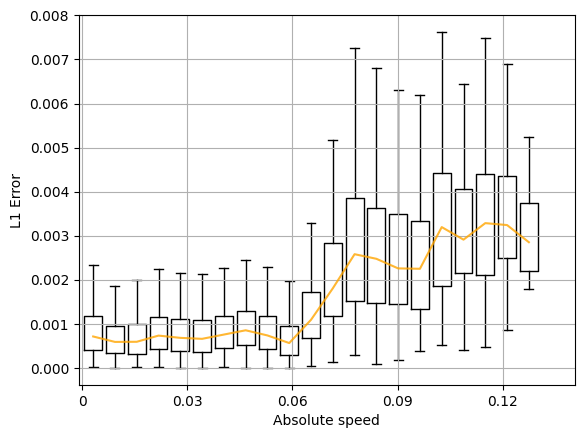

In [63]:
_ = plotBoxPlot2(speed_norm, errors, bins, xlabel = 'Speed Norm', ylabel = 'L1 Error')